<a href="https://colab.research.google.com/github/UtkarshMains/AI-assignment/blob/main/80epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Starting Training Loop...
[0/80][0/22] Loss_D: 1.3531 Loss_G: 3.3308 D(x): 0.4976 D(G(z)): 0.4660 / 0.0374
Validation Losses - Discriminator: 2.7750, Generator: 0.6570
[1/80][0/22] Loss_D: 2.1880 Loss_G: 12.3685 D(x): 0.8696 D(G(z)): 0.8592 / 0.0000
Validation Losses - Discriminator: 1.9880, Generator: 1.8854
[2/80][0/22] Loss_D: 0.0494 Loss_G: 4.9568 D(x): 0.9596 D(G(z)): 0.0070 / 0.0076
Validation Losses - Discriminator: 3.2386, Generator: 6.1216
[3/80][0/22] Loss_D: 0.1683 Loss_G: 7.5456 D(x): 0.8583 D(G(z)): 0.0011 / 0.0006
Validation Losses - Discriminator: 2.9250, Generator: 1.8423
[4/80][0/22] Loss_D: 0.0935 Loss_G: 6.2037 D(x): 0.9423 D(G(z)): 0.0302 / 0.0023
Validation Losses - Discriminator: 2.9488, Generator: 5.8752
[5/80][0/22] Loss_D: 0.5881 Loss_G: 3.6724 D(x): 0.8293 D(G(z)): 0.2274 / 0.0462
Validation Losses - Discriminator: 2.6353, Generator: 3.7388
[6/80][0/22] Loss_D: 2.5455 Loss_G: 3.3454 D(x): 0.1175 D(G(z)): 0.0089 / 0.0472
Validation Losses - Discriminator: 1.158

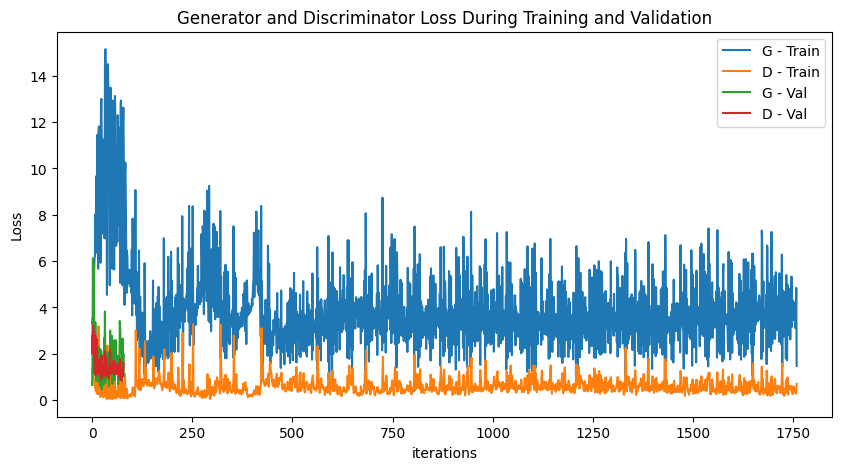

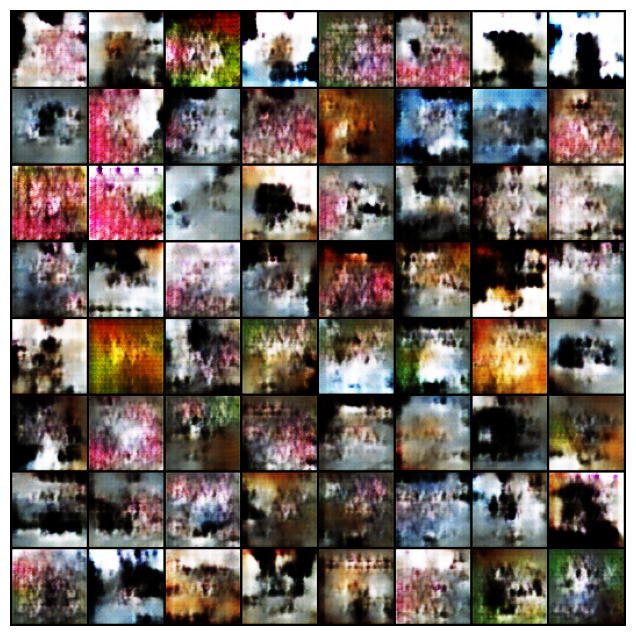

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split


data_path = './drive/MyDrive/CAT_00/cat'


batch_size = 64
image_size = 64
nz = 100
ngf = 64
ndf = 64
num_epochs = 80
lr = 0.0002
beta1 = 0.5


transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


dataset = dsets.ImageFolder(root=data_path, transform=transform)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)


netG = Generator().cuda()


netD = Discriminator().cuda()


criterion = nn.BCELoss()


fixed_noise = torch.randn(64, nz, 1, 1).cuda()


real_label = 1
fake_label = 0


optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

img_list = []
G_losses = []
D_losses = []
G_val_losses = []
D_val_losses = []

print("Starting Training Loop...")
iters = 0
for epoch in range(num_epochs):
    for i, data in enumerate(train_dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].cuda()
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device="cuda")
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1).cuda()
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()


        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(train_dataloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    netG.eval()
    netD.eval()
    val_D_losses = 0
    val_G_losses = 0
    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            real_cpu = data[0].cuda()
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device="cuda")
            output = netD(real_cpu).view(-1)
            errD_real = criterion(output, label)
            D_x = output.mean().item()

            noise = torch.randn(b_size, nz, 1, 1).cuda()
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake).view(-1)
            errD_fake = criterion(output, label)
            errD = errD_real + errD_fake
            val_D_losses += errD.item()

            label.fill_(real_label)
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            val_G_losses += errG.item()

    val_D_losses /= len(val_dataloader)
    val_G_losses /= len(val_dataloader)
    D_val_losses.append(val_D_losses)
    G_val_losses.append(val_G_losses)
    netG.train()
    netD.train()

    print(f'Validation Losses - Discriminator: {val_D_losses:.4f}, Generator: {val_G_losses:.4f}')

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training and Validation")
plt.plot(G_losses,label="G - Train")
plt.plot(D_losses,label="D - Train")
plt.plot(G_val_losses,label="G - Val")
plt.plot(D_val_losses,label="D - Val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())


torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')


def generate_cats(num_images, model_path='generator.pth', nz=100, save_dir='generated_cats'):
    os.makedirs(save_dir, exist_ok=True)

    netG = Generator().cuda()
    netG.load_state_dict(torch.load(model_path))
    netG.eval()

    for i in range(num_images):
        noise = torch.randn(1, nz, 1, 1).cuda()
        with torch.no_grad():
            fake = netG(noise).detach().cpu()
        img = vutils.make_grid(fake, padding=2, normalize=True).numpy()
        img = np.transpose(img, (1, 2, 0))

        plt.imsave(f"{save_dir}/cat_{i+1}.png", img)


generate_cats(10)
